<h1><center>ML Flow</center></h1>

https://mlflow.org/

https://towardsdatascience.com/getting-started-with-mlflow-52eff8c09c61#:~:text=mlFlow%20is%20a%20framework%20that,each%20with%20it's%20own%20capabilities

https://www.mlflow.org/docs/latest/tutorials-and-examples/tutorial.html

https://docs.databricks.com/_static/notebooks/mlflow/mlflow-quick-start-training.html

<hr>

# Explanation

"*MLflow is an open source platform to manage the ML lifecycle, including experimentation, reproducibility, deployment, and a central model registry.*" - a description from the 'ML Flow' website.

Essentially, ML Flow is a framework that supports the machine learning lifecycle. It has components to monitor your model during training and running, ability to store models, load the model in production code and create a pipeline.

MLflow currently offers three main componenets, with a fourth that won't really be used:

### 1. MLflow Tracking:

Record and query experiments: code, data, config, and results.<br>
Tracking allows you to create an extensive logging framework around your model. You can define custom metrics so that after a run you can compare the output to previous runs.

### 2. MLflow Projects:
Package data science code in a format to reproduce runs on any platform.<br>
This feature allows you to create a pipeline if you so desire, using its own template to define how you want to run the model on a cloud environment. **Note:** most companies have a way to run code in production.

### 3. MLflow Models:
Deploy machine learning models in diverse serving environments.<br>
A ML Flow model is a standard format for packaging machine learning models that can be used in a variety of downstream tools, e.g. real-time serving through a REST API.

### 4. Model Registry:
Store, annotate, discover, and manage models in a central repository

# Example

In this example you will use MLflow end-to-end to:

- Train a linear regression model (**ElasticNet**)
- Package the code that trains the model in a reusable and reproducible model format
- Deploy the model into a simple HTTP server that will enable you to score predictions

The model will use a dataset to predict the quality of wine based on quantitative features: fixed acidity, pH, residual sugar etc.

With the model created, the MLflow tracking APIs log information about each training run, e.g. the alpha and l1_ratio hyperparameters, information used to train the model and metrics used to evaluate the model, e.g. the root mean square error.<br>
The example also serializes the model in a format that MLflow knows how to deploy.

## Import Modules

In [1]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn

import logging
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)
# Formatting a logger for errors, with error_level WARN
    # Not essential for ML Flow

## Evaluation Function

In [2]:
def eval_metrics(actual, pred):
    
    rmse = np.sqrt(mean_squared_error(actual, pred))
    
    mae = mean_absolute_error(actual, pred)
    
    r2 = r2_score(actual, pred)
    
    return rmse, mae, r2

## Train Linear Regression Model

Firstly, read the necessary csv files and train a linear regression model that takes two hyperparameters, **alpha** and **l1_ratio**:

In [14]:
warnings.filterwarnings("ignore")
np.random.seed(40)

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

                        # Read the wine-quality csv file from the URL

csv_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'

try:    
    data = pd.read_csv(csv_url, sep=';')
    
except Exception as e:    
        logger.exception(
            "Unable to download training & test CSV, check your internet connection. Error: %s", e)
        
print(data.head())
        
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
        
                        # Split the data into training and test sets
        
# Split code from previous models:
    #X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
    
train, test = train_test_split(data)
    
# The predicted column is "quality" which is a scalar from [3, 9]
    # All the columns are part of the X_train/test series, EXCEPT "quality" hence why it's dropped
X_train = train.drop(["quality"], axis=1)
X_test = test.drop(["quality"], axis=1)    
    
Y_train = train["quality"]
Y_test = test["quality"]

# Original code (float error):
    #alpha = float(sys.argv[1]) if len(sys.argv) > 1 else 0.5
    #l1_ratio = float(sys.argv[2]) if len(sys.argv) > 2 else 0.5

alpha = float(len(sys.argv[1])) if len(sys.argv) > 1 else 0.5

l1_ratio = float(len(sys.argv[2])) if len(sys.argv) > 2 else 0.5

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

## (Optional) Set_tracking_uri

This sets where the data from each run of the ML Flow will be kept. The data is saved in the folder *mlruns* within folder 0.

By default, the files are stored in the same file directory as the Python file. The **mlflow.set_tracking_uri()** function can reset where the data will be saved; the Uniform Resource Identifier (URI) can either be for a remote server (http/https), a database connection string, or a local path to log data to a directory.

**Note:** when setting a new URI, the directory has to end with */mlruns*, otherwise an error will occur.

In [4]:
# Currect directory:
#mlflow.set_tracking_uri("file:///C:/Users/nathi_000/Desktop/Python%20Files/NLP%20Project/mlruns")

#mlflow.set_tracking_uri("file:///C:/Users/nathi_000/Desktop/Python%20Files/NLP%20Project/Files/mlruns")

## Start the ML Flow

The flow is started with *mlflow.start_run()*; the model is then fitted with the data, with the evaluation metrics calculated for the model.<br>
Standard stuff at the moment.

## Log the Parameters and Metrics

Using the mlflow functions *.log_param*, for the model's parameters, and *.log_metric*, for the model's metrics, the MLFlow's details can be stored in the flow.

## Log the model

*mlflow.sklearn.log_model()* will log the details into the specified directory.

In [5]:
                        # Start the ML Flow

# Start an MLflow run - the "with" keyword ensures the run is closed even if this cell crashes
with mlflow.start_run():
    
    LinReg = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    
    LinReg.fit(X_train, Y_train)
    
    predicted = LinReg.predict(X_test)
    
    rmse, mae, r2 = eval_metrics(Y_test, predicted)
    # Use function to get metrics
    
    # Print out metrics
    print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
    
                        # Log mlflow attributes into the mlflow
        
    # Parameters
    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    
    # Metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

# Can set where to put the ML Flow information
    #mlflow.set_tracking_uri(mlflow_tracking_URI)
        # Currently: C:\Users\nathi_000\Desktop\Python Files\NLP Project\mlruns
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
    
                        # Log the model's details
    
    # Model registry does not work with file store
    if tracking_url_type_store != "file":
        
        # Register the model
        # There are other ways to use the Model Registry, which depends on the use case,
        # please refer to the doc for more information:
        # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        
        mlflow.sklearn.log_model(LinReg, "model", registered_model_name="ElasticnetWineModel")
        
    else:
        mlflow.sklearn.log_model(LinReg, "model")

Elasticnet model (alpha=2.000000, l1_ratio=99.000000):
  RMSE: 0.8426394848604892
  MAE: 0.7025396163469558
  R2: -0.006044846368814971


Each time you run the example, ML Flow logs information about each experiment in the directory *mlruns*.

# MLFlow UI

You can view each time the model has been run, plus compare models in **MLFlow UI**.

This is done by running the command line, going to the directory containing the **mlruns** folder and entering the command:

<center><span style="font-size:20px">mlflow ui</span></center>

<hr>

<span style="color:white; background-color:red">NOTE:</span>

This has only worked on Anaconda Prompt's command line.

Unsure why but i hasn't worked on the computer's or Git Bash's command lines.

<hr>

# Example - Logistic Regression Model, NLP Project

For a complete example, I will construct a Logisitic Regression model which will loop through two different vectorisers, CountVectoriser (Bag-of-Words) and TF-IDF. The parameters and metrics will be logged using ML Flow and compared on the UI.

In addition to logging the metrics, I will also log a **Confusion Matrix** for each model to be viewed on the UI.

In [80]:
                        # Imports
    
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import string
from spacy.lang.en.stop_words import STOP_WORDS
import nltk
import re
from sklearn.multiclass import OneVsRestClassifier

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp
from urllib.parse import urlparse

import requests
import io
import mlflow
import mlflow.sklearn

import logging
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)
# Formatting a logger for errors, with error_level WARN
    # Not essential for ML Flow

import os
import errno

In [81]:
                        # Functions
    
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

                        # Metrics Function

def get_metrics(Y_test, predicted): 
    
    # true positives / (true positives+false positives)
    precision = precision_score(Y_test, predicted, pos_label=None,
                                    average='weighted')
    
    # true positives / (true positives + false negatives)
    recall = recall_score(Y_test, predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(Y_test, predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(Y_test, predicted)
    
    return accuracy, precision, recall, f1

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

                        # Text Cleaner Function

def text_cleaner(sentence):
    
    Lemmatiser = nltk.stem.WordNetLemmatizer()
    # Instantiating the NLTK Lemmatiser

    punctuations = string.punctuation
    # Putting punctuation symbols into an object

    stopwords = STOP_WORDS
    # A list of stopwords that can be filtered out
                    
    sentence = "".join([char for char in sentence.strip() if char not in punctuations])
    # Getting rid of any punctuation characters
    
    myTokens = re.split(r'\W+', sentence)
    # Tokenising the words
    
    myTokens = [token.lower() for token in myTokens if token not in stopwords]
    # Removing stop words
    
    myTokens = [Lemmatiser.lemmatize(token) for token in myTokens]
    # Lemmatising the words and putting in lower case except for proper nouns
    
    return myTokens

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

                        # Create new file directory function
    
def Create_FileDirectory(filepath):
    
    if not os.path.exists(os.path.dirname(filepath)):
    # If the Filepath directories don't exist...
        
        try:
            os.makedirs(os.path.dirname(filepath))
            # Create the directories that don't exist
            
        except OSError as exc:
        # Guard against race condition
        
            if exc.errno != errno.EEXIST:                
                raise

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

                        # Confusion Matrix generating function

def generate_ConfusionMatrix(Y_test, predicted, labels, classifier):
    
    from datetime import datetime

    cm = metrics.confusion_matrix(Y_test, predicted, labels)
    
    date_time = datetime.now().strftime("%d-%m-%Y__%H_%M_%S")
    filepath = "Images/mlruns_figures/CM_" + date_time + ".png"
    
    Create_FileDirectory(filepath)
    # Check if the folders exist, AND create if they are not
    
    fig = plt.figure(figsize=[8,8])
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion Matrix of %s\n' % classifier)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.text(0.5, 3.2, cm, color="black", fontsize=15)
    
    plt.show()
    fig.savefig(filepath)
    #plt.close(fig)
    
    return filepath

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

                        # Create an experiment / get experiment Id function
                
# Create an experiment to put data for relevant models in

def GetExper_CreateExper(Experiment_Name):
# Experiment_Name = STRING - name of experiment in mlruns folder, or create a new one
    
    try:
        exp_id = mlflow.get_experiment_by_name(Experiment_Name).experiment_id
        # Inputs:
            # name = the experiment's name
        # Returns: Experiment object
            # .value wanted from object
    
    except AttributeError: # Error if experiment already created
        exp_id = mlflow.create_experiment(Experiment_Name)
        # Inputs:
            # name = the experiment's name (unique)
            # artifact_location (optional) = location to store run artifacts
        # Returns: integer Id of the experiment
    
    return exp_id

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

                        # Create Sentiment Analysis Model's name function
    
def SAM_Name(pipe):
    
    SAM = str(pipe.named_steps['classifier'])
    
    match = re.search("estimator", SAM)
    
    if match:
        n = 1
    else:
        n = 0
        
    SAM = SAM.split("(")[n].replace("estimator=","").strip()
    
    return SAM

In [82]:
                        # Reading .csv file

# Training csv file
url_train = "https://raw.githubusercontent.com/SoniaLei/nlp-web-scrapping/development/data/raw/tweets-train.csv"
csv_train = requests.get(url_train).content
df_train = pd.read_csv(io.StringIO(csv_train.decode('utf-8')))

# Testing csv file
url_test = "https://raw.githubusercontent.com/SoniaLei/nlp-web-scrapping/development/data/raw/tweets-test.csv"
csv_test = requests.get(url_test).content
df_test = pd.read_csv(io.StringIO(csv_test.decode('utf-8')))

X_train = df_train['text'].astype(str)
Y_train = df_train['sentiment'].astype(str)

X_test = df_test['text'].astype(str)
Y_test = df_test['sentiment'].astype(str)

In [83]:
                        # Create Vectorisers

bow_vector = CountVectorizer(tokenizer = text_cleaner, ngram_range=(1,1))

tfidf_vector = TfidfVectorizer(tokenizer = text_cleaner)

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

                        # Add Vectorisers to List
    
ListOfVectorisers = [bow_vector, tfidf_vector]

In [84]:
                        # Building OVR Logisitic Regression Classifier

LogReg = LogisticRegression(max_iter=1000)

ovr = OneVsRestClassifier(LogReg)

Model = LogisticRegression: Vectoriser = CountVectorizer
  Accuracy: 0.702037351443124
  Precision: 0.7064065097350465
  Recall: 0.702037351443124
  F-Score: 0.7026855438398288



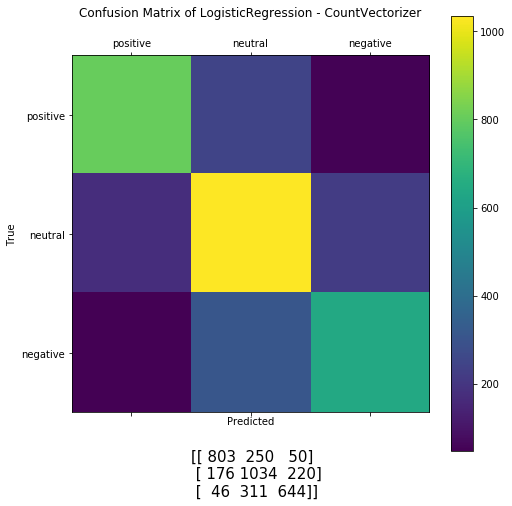

Model = LogisticRegression: Vectoriser = TfidfVectorizer
  Accuracy: 0.7034521788341822
  Precision: 0.714553624985777
  Recall: 0.7034521788341822
  F-Score: 0.7041589633254353



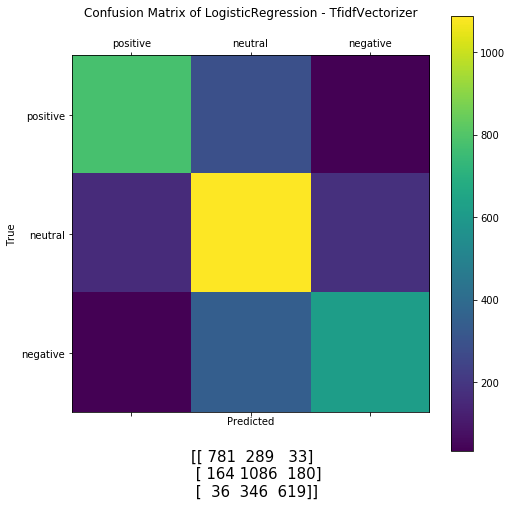

In [85]:
                        # Start loop through the 2 vectorisers

# Setting where the data is stored:

mlflow.set_tracking_uri("file:///C:/Users/nathi_000/Desktop/Python Files/NLP Project/nlp-web-scrapping/mlruns")
# Set the save point for the files into my Github development branch

#mlflow.set_tracking_uri("file:///C:/Users/nathi_000/Desktop/Python Files/NLP Project/mlruns")
# Set the save point as the same directory as my file

######################################################
    # This will need to be altered for each person
######################################################

exp_id = GetExper_CreateExper("Logistic Regression")
# Get experiment id for add parameters, metrics and figures for this run
    
for vectoriser in ListOfVectorisers:
    
    # Start ML Flow
    with mlflow.start_run(experiment_id = exp_id, run_name="LogReg_Vectors"):
        
        pipe = Pipeline([('vectorizer', vectoriser)
                         ,('classifier', ovr)])
            
        pipe.fit(X_train, Y_train)
        
        predicted = pipe.predict(X_test)
        
        accuracy, precision, recall , f1 = get_metrics(Y_test, predicted)
        
        # Get Vectoriser's name
        vectoriser = str(pipe.named_steps['vectorizer']).split("(")[0].strip()
        
        SAM = SAM_Name(pipe)
                
        # Print out metrics
        print("Model = %s: Vectoriser = %s" % (SAM, vectoriser))
        print("  Accuracy: %s" % accuracy)
        print("  Precision: %s" % precision)
        print("  Recall: %s" % recall)
        print("  F-Score: %s\n" % f1)
        
        # Create and print out figures
        labels = ['positive','neutral','negative']
        classifier = SAM + " - " + vectoriser
        
        Filepath = generate_ConfusionMatrix(Y_test, predicted, labels, classifier)
        
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
        
        # Log mlflow attributes into the mlflow
        
        # Parameters
        mlflow.log_param("SAM", SAM)
        mlflow.log_param("Vectoriser", vectoriser)
    
        # Metrics
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Precision", precision)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F-Score", f1)
                
        # Figures
        mlflow.log_artifact(Filepath)
        
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
    
                        # Log the model's details
        
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    
        # Model registry does not work with file store
        if tracking_url_type_store != "file":
        
            # Register the model
            # There are other ways to use the Model Registry, which depends on the use case,
            # please refer to the doc for more information:
            # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        
            mlflow.sklearn.log_model(pipe, "model", registered_model_name="LogisticRegression")
        
        else:
            mlflow.sklearn.log_model(pipe, "model")